# Data Visualization <a class="tocSkip">
Author: Stefan Roland Schwingenschlögl <br>
email: stefan.roland.schwingenschloegl@gmail.com <br>
github: github.com/stefan-schwingenschloegl <br>
___
*Projekt File No: 5 <br>*

In [1]:
import numpy as np
import pandas as pd

import pyodbc

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# set the path to the Wiener Linien API documentation
wl_docu_url = 'http://www.wienerlinien.at/ogd_realtime/doku/'

# set the URL to the Wiener Linien API real time monitor
wl_monitor_url = 'http://www.wienerlinien.at/ogd_realtime/monitor?'

# set consistens figure dimensions
fig_dim = (10, 5)

# hexadecimal colorcode from the Wiener Linien logo
wl_col = ['#e3010f', '#240b4c', '#f8ecec', '#db7778', '#ce5155', '#be919e', '#7c8494']
wl_palette = sns.color_palette(wl_col)

# set plot style
plt.style.use('ggplot')

# set properties for database
db_name = 'WienerLinienDB'
server = 'DESKTOP-JV1HTQR\SQLEXPRESS'
db_connection = False

# Initialize general methods

In [3]:
# establish DB Connection
def db_connect(server, db_name):
    """
    Establish database connection
    
    input args: server, db_name as string format
    return args: database connection object
    """
    conn = pyodbc.connect("driver={SQL Server};server="+server+"; database="+db_name+"; trusted_connection=true")
    db_connection = True
   # print(f"\nConnection with {server} sucessfull!\n"
    #      f"Current Database: {db_name}\n"
    #      f"DB Connection Status: {db_connection}")
    return conn

In [4]:
# close DB Connection
def close_connection(server, conn):
    conn.close()
    db_connection = False
   # print(f"\nDB-Connection with Server {server} closed.\n"
   #       f"DB Connections Status: {db_connection}")

In [5]:
def get_stage_delay():
    conn = db_connect(server, db_name)
    
    with conn:
        df = pd.read_sql(f"select * from stage_delay", conn)
    
    close_connection(server, conn)
    
    return df

In [6]:
df = get_stage_delay()

In [7]:
# cast all string columns to category and all numeric columns to int, besides datetime and float types
def cast_columns(df):
    print(f'Types before: \n{df.dtypes}\n')
    for col in df.columns:
        if 'time' in col:
            df[col] = pd.to_datetime(df[col])
            continue
        elif df[col].dtypes == 'float64':
            continue
        try: 
            df[col] = df[col].astype('int64')
        except ValueError:
            df[col] = df[col].astype('category')
    print(f'Types afterwards: \n{df.dtypes}')
    return df

df = cast_columns(df)

Types before: 
timestamp       object
stop_name       object
line_name       object
lineID          object
towards         object
richtungsID     object
type            object
timePlanned     object
timeReal        object
DIVA             int64
rbl              int64
delay          float64
dtype: object

Types afterwards: 
timestamp      datetime64[ns]
stop_name            category
line_name            category
lineID                  int64
towards              category
richtungsID             int64
type                 category
timePlanned    datetime64[ns]
timeReal       datetime64[ns]
DIVA                    int64
rbl                     int64
delay                 float64
dtype: object


# EDA
___
## Data Cleaning

### Get missing Values

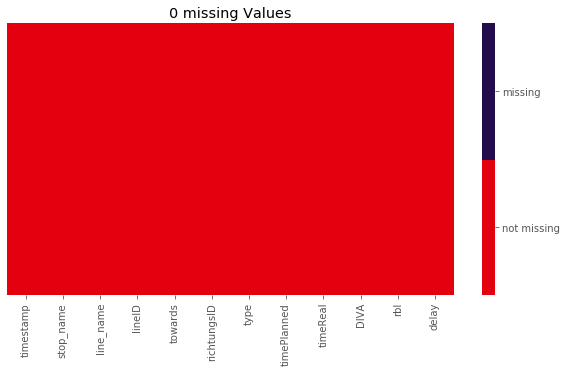

In [8]:
def get_amount_of_na(df):
    amount = df.isna().sum().sum().astype(str)
    return amount

def visualize_na(df, fig_dim):
    plt.figure(figsize = fig_dim)
    ax = sns.heatmap(df.isna(),
            yticklabels=False,
            vmin=0,
            vmax=1,
            cmap=wl_palette[:2],
            cbar=True)
    ax.set_title(f'{get_amount_of_na(df)} missing Values')
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0.25, 0.75])
    cbar.set_ticklabels(['not missing', 'missing'])
    

visualize_na(df, fig_dim)  

So there are no missing values in the dataset. 

### delay by type

In [9]:
def validate_input(x, y):
    if x not in df.columns or y not in df.columns:
        raise ValueError('At least one of your input arguments is not in the columns of the dataframe. Please check!')
    

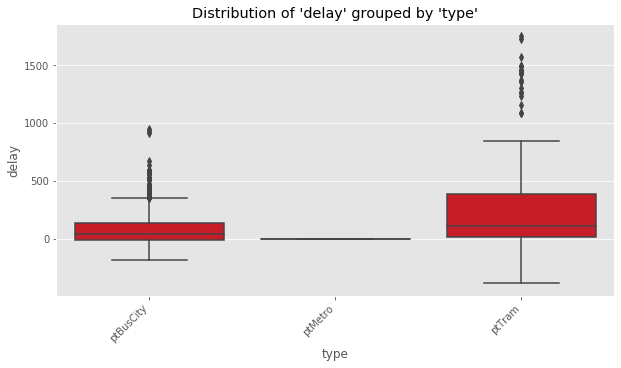

In [10]:
def plot_boxplot(df, x, y, fig_dim = (10,5)):
    validate_input(x,y)
        
    plt.figure(figsize = fig_dim)
    ax = sns.boxplot(x=x,
                     y=y,
                     data=df,
                     color = wl_palette[0])
    ax.set_title(f"Distribution of '{y}' grouped by '{x}'")
    ax.set_xticklabels(ax.get_xticklabels(), 
                          rotation=45,
                          ha='right')
    

plot_boxplot(df,'type', 'delay', fig_dim)

In [11]:
df[['type','delay']].groupby('type').describe()

delay                                                             
            count        mean         std    min    25%    50%     75%     max
type                                                                          
ptBusCity  1490.0   70.921477  132.970590 -184.0 -12.00   38.0  134.00   946.0
ptMetro     596.0    0.000000    0.000000    0.0   0.00    0.0    0.00     0.0
ptTram      298.0  264.285235  393.609425 -388.0  17.25  111.0  387.25  1753.0

It can be seen that there is very little dispersion in the delays of the metro. Upon further investigation, it can be seen that not a single metro was even a single second late or early. From my own experience I can say that this is not really realistic ;-) <br>
For this reason, all entries of subways are therefore removed. The remaining values look realistic.

In [12]:
df = df.loc[df['type'] != 'ptMetro']
df['type'].cat.remove_unused_categories(inplace=True)

In [13]:
df[['type','delay']].groupby('type').describe()

delay                                                             
            count        mean         std    min    25%    50%     75%     max
type                                                                          
ptBusCity  1490.0   70.921477  132.970590 -184.0 -12.00   38.0  134.00   946.0
ptTram      298.0  264.285235  393.609425 -388.0  17.25  111.0  387.25  1753.0

### Number of entries by stopname

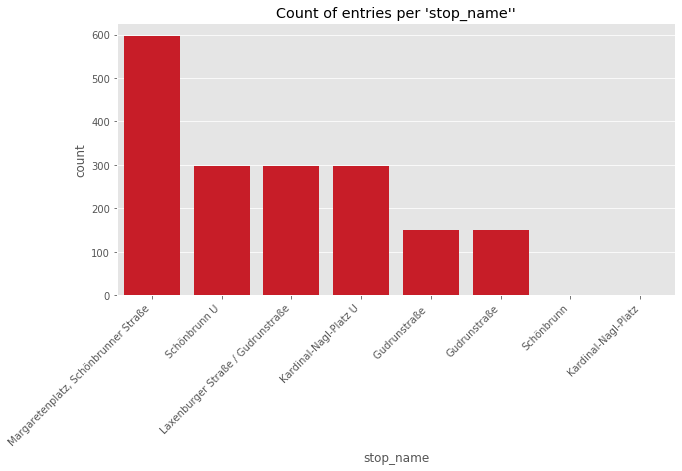

In [14]:
def val_count(df, col, hue=None):
    if col not in df.columns:
        raise ValueError('At least one of your input arguments is not in the columns of the dataframe. Please check!')
        
    plt.figure(figsize = fig_dim)
    ax = sns.countplot(x=col,
                       data=df,
                       color=wl_palette[0],
                       order=df[col].value_counts().index,
                       hue=hue)
    
    ax.set_title(f"Count of entries per '{col}''")
    ax.set_xticklabels(ax.get_xticklabels(), 
                          rotation=45,
                          ha='right')
    
val_count(df, 'stop_name')

Here you can see that the two stations 'Schönbrunn' and 'Kardinal-Nagl-Platz' probably only provided entries that were used by underground trains. Therefore, these two stop_names can also be dropped in this analysis. It is also interesting that there are probably two entries with the name 'Gudrunstraße'. In the next step, it would be interesting to see what the difference is. It is also interesting that 'Laxenburger Straße/Gudrunstraße' is listed separately. These three stop_names will be given attention in the next step.

In [15]:
# get DIVA name of all stops which contains 'Gudrunstraße'
df.loc[df['stop_name'].str.contains('Gudrunstraße'), 'DIVA'].unique()

array([60200136], dtype=int64)

In [16]:
# all lines which stop at 'Laxenburger Straße / Gudrunstraße'
df.loc[df['stop_name'] == 'Laxenburger Straße / Gudrunstraße', 'line_name'].unique()

[14A]
Categories (1, object): [14A]

In [17]:
# all lines which stop at 'Gudrunstraße'
df.loc[df['stop_name'] == 'Gudrunstraße', ['line_name', 'towards']]

,line_name,towards
10,O,Bruno-Marek-Allee
26,O,Bruno-Marek-Allee
42,O,Bruno-Marek-Allee
58,O,Bruno-Marek-Allee
74,O,Bruno-Marek-Allee
...,...,...
2314,O,Bruno-Marek-Allee
2330,O,Bruno-Marek-Allee
2346,O,Bruno-Marek-Allee
2362,O,Bruno-Marek-Allee


In [18]:
# all lines which stop at 'Gudrunstraße'
df.loc[df['stop_name'] == 'Gudrunstraße ', ['line_name', 'towards']]

,line_name,towards
11,O,"Raxstraße, Rudolfshügelgasse"
27,O,"Raxstraße, Rudolfshügelgasse"
43,O,"Raxstraße, Rudolfshügelgasse"
59,O,"Raxstraße, Rudolfshügelgasse"
75,O,"Raxstraße, Rudolfshügelgasse"
...,...,...
2315,O,"Raxstraße, Rudolfshügelgasse"
2331,O,"Raxstraße, Rudolfshügelgasse"
2347,O,"Raxstraße, Rudolfshügelgasse"
2363,O,"Raxstraße, Rudolfshügelgasse"


It can now be seen that at 'Laxenburger Straße / Gudrunstraße' only line '14A' stops in both directions. At 'Gudrunstraße' only line 'O' runs in the direction of 'Bruno-Marek-Alle'. For the route in the other direction, there must have been a typing error. This name is 'Gudrunstraße ' and at this one the line 'O' goes in the direction of 'Raxstraße, Rudolfshügelgasse'. After this all leaves at a DIVA, the name is changed for all to 'Gudrunstraße'.

In [19]:
df

,timestamp,stop_name,line_name,lineID,towards,richtungsID,type,timePlanned,timeReal,DIVA,rbl,delay
0,2020-12-17 08:30:00,Schönbrunn U,10A,410,Niederhofstraße U,1,ptBusCity,2020-12-17 08:28:30,2020-12-17 08:38:11,60201211,723,581.0
1,2020-12-17 08:30:00,Schönbrunn U,10A,410,Bhf. Heiligenstadt S U,2,ptBusCity,2020-12-17 08:32:30,2020-12-17 08:33:32,60201211,724,62.0
2,2020-12-17 08:30:00,"Margaretenplatz, Schönbrunner Straße",12A,412,Eichenstraße,1,ptBusCity,2020-12-17 08:29:30,2020-12-17 08:35:47,60200829,670,377.0
3,2020-12-17 08:30:00,"Margaretenplatz, Schönbrunner Straße",13A,413,Hauptbahnhof S U,1,ptBusCity,2020-12-17 08:32:00,2020-12-17 08:32:29,60200829,670,29.0
4,2020-12-17 08:30:00,"Margaretenplatz, Schönbrunner Straße",13A,413,"Alser Straße, Skodagasse",2,ptBusCity,2020-12-17 08:28:30,2020-12-17 08:33:01,60200829,698,271.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2375,2020-12-17 10:59:59,"Margaretenplatz, Schönbrunner Straße",59A,459,"Oper, Karlsplatz U",2,ptBusCity,2020-12-17 11:01:30,2020-12-17 11:01:08,60200829,1701,-22.0
2376,2020-12-17 10:59:59,Kardinal-Nagl-Platz U,77A,477,Stadlauer Brücke,1,ptBusCity,2020-12-17 11:00:30,2020-12-17 11:00:41,60200653,257,11.0
2377,2020-12-17 10:59:59,Kardinal-Nagl-Platz U,77A,477,Rennweg S,2,ptBusCity,2020-12-17 10:56:30,2020-12-17 11:02:26,60200653,263,356.0
2378,2020-12-17 10:59:59,Gudrunstraße,O,170,Bruno-Marek-Allee,1,ptTram,2020-12-17 11:01:20,2020-12-17 11:01:00,60200136,300,-20.0


In [20]:
 df['stop_name'] = df['stop_name'].replace(dict.fromkeys(['Gudrunstraße ','Laxenburger Straße / Gudrunstraße'], 'Gudrunstraße'))

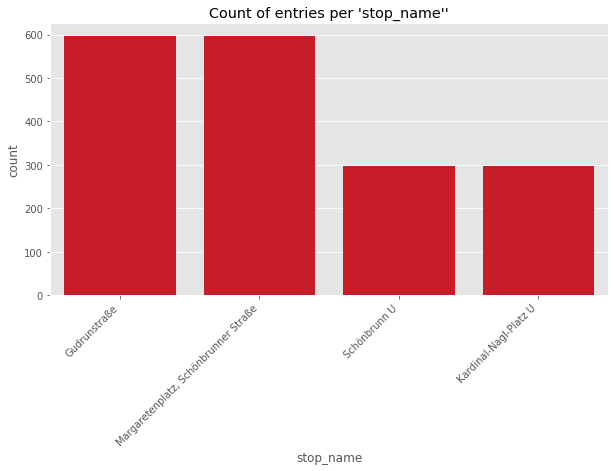

In [21]:
val_count(df, 'stop_name')

In [22]:
df.loc[df['stop_name'] == 'Margaretenplatz, Schönbrunner Straße']

,timestamp,stop_name,line_name,lineID,towards,richtungsID,type,timePlanned,timeReal,DIVA,rbl,delay
2,2020-12-17 08:30:00,"Margaretenplatz, Schönbrunner Straße",12A,412,Eichenstraße,1,ptBusCity,2020-12-17 08:29:30,2020-12-17 08:35:47,60200829,670,377.0
3,2020-12-17 08:30:00,"Margaretenplatz, Schönbrunner Straße",13A,413,Hauptbahnhof S U,1,ptBusCity,2020-12-17 08:32:00,2020-12-17 08:32:29,60200829,670,29.0
4,2020-12-17 08:30:00,"Margaretenplatz, Schönbrunner Straße",13A,413,"Alser Straße, Skodagasse",2,ptBusCity,2020-12-17 08:28:30,2020-12-17 08:33:01,60200829,698,271.0
7,2020-12-17 08:30:00,"Margaretenplatz, Schönbrunner Straße",59A,459,"Oper, Karlsplatz U",2,ptBusCity,2020-12-17 08:34:30,2020-12-17 08:36:58,60200829,1701,148.0
18,2020-12-17 08:30:59,"Margaretenplatz, Schönbrunner Straße",12A,412,Eichenstraße,1,ptBusCity,2020-12-17 08:29:30,2020-12-17 08:35:55,60200829,670,385.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2359,2020-12-17 10:59:00,"Margaretenplatz, Schönbrunner Straße",59A,459,"Oper, Karlsplatz U",2,ptBusCity,2020-12-17 11:01:30,2020-12-17 11:01:18,60200829,1701,-12.0
2370,2020-12-17 10:59:59,"Margaretenplatz, Schönbrunner Straße",12A,412,Eichenstraße,1,ptBusCity,2020-12-17 11:09:30,2020-12-17 11:10:08,60200829,670,38.0
2371,2020-12-17 10:59:59,"Margaretenplatz, Schönbrunner Straße",13A,413,Hauptbahnhof S U,1,ptBusCity,2020-12-17 10:58:00,2020-12-17 11:05:32,60200829,670,452.0
2372,2020-12-17 10:59:59,"Margaretenplatz, Schönbrunner Straße",13A,413,"Alser Straße, Skodagasse",2,ptBusCity,2020-12-17 11:02:30,2020-12-17 11:01:34,60200829,698,-56.0


Now it can be seen that only 4 different stop_names remain for the 4 different DIVA numbers. It is interesting to see that for 'Margaretenplatz, Schönbrunner Straße' and for 'Gudrunstraße' there are exactly twice as many entries as for 'Kardinal-Nagl-Platz U' and 'Schönbrunn U'. Why this is so will be investigated further.

In [23]:
# get amount of distinct lines per stop_name
df.groupby('stop_name').agg({'line_name': 'nunique'})

,line_name
stop_name,
Gudrunstraße,2
Kardinal-Nagl-Platz U,1
"Margaretenplatz, Schönbrunner Straße",3
Schönbrunn U,1


Here you can see that 3 different lines stop at one station, 2 at another and only 1 at each of the last two. The question now arises as to how it can be that although different numbers of different lines stop there, the same number of entries are still stored.

In [24]:
# get amount of directions per line
df.groupby(['stop_name', 'line_name']).agg({'richtungsID': 'nunique'})

richtungsID
stop_name                            line_name             
Gudrunstraße                         10A                  0
                                     12A                  0
                                     13A                  0
                                     14A                  2
                                     59A                  0
                                     77A                  0
                                     O                    2
                                     U3                   0
                                     U4                   0
Kardinal-Nagl-Platz U                10A                  0
                                     12A                  0
                                     13A                  0
                                     14A                  0
                                     59A                  0
                                     77A                  2
                                     O                    0
                                     U3                   0
                                     U4                   0
Margaretenplatz, Schönbrunner Straße 10A                  0
                                     12A                  1
                                     13A                  2
                                     14A                  0
                                     59A                  1
                                     77A                  0
                                     O                    0
                                     U3                   0
                                     U4                   0
Schönbrunn U                         10A                  2
                                     12A                  0
                                     13A                  0
                                     14A                  0
                                     59A                  0
                                     77A                  0
                                     O                    0
                                     U3                   0
                                     U4                   0

As a result, it can be seen that at the two stations with fewer entries, one line runs in each of two directions. At 'Gudrunstraße' two lines run in two directions. At 'Margaretenplatz, Schönbrunner Straße' three different lines stop. However, at this DIVA number, lines '12A' and '59A' only stop for one direction. Line '13A' stops again in both directions. <br>
Therefore, a total of 12 * 149 = 1788 entries were read in. This coincides with the number of entries in the dataframe.

### Reduce dataframe to get only last Entry per planned depature
With the workflow, the current delay of the next vehicle was queried once per minute. If a vehicle now has an extremely long delay, this vehicle would very often be counted as a delay. To prevent this, only the last entry of each vehicle before the next one arrives is retained in the data. This is done by grouping by 'timePlanned', 'stop_name', 'line_name', 'directionID' and keeping only the last entry. This reduces the dataset to $\sim \frac{1}{6}$ of the respective output set.

In [25]:
df_red = df.groupby(['timePlanned', 'stop_name', 'line_name', 'richtungsID']).tail(1)

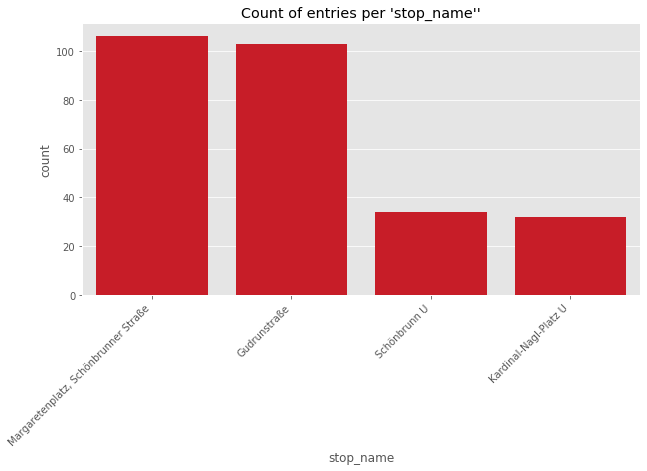

In [26]:
val_count(df_red, 'stop_name')

## Data Exploration
___
### General delay per station
Die Eingangsfrage welche geklärt werden sollte war welche Station die geringsten Verspätungen aufweisen kann. Dies wird nun im Zuge dieses Abschnittes geklärt. Hierzu wird hier nach den verschiedenen Stationen gruppiert und für jede Station die Verteilung mittels Zahlenwerten evaluiert, sowie graphisch mit einem Boxplot dargestellt. Hier wird ein erstes Fazit zur Beantwortung der Fragestellung gezogen.

,count,mean,std,min,25%,50%,75%,max
stop_name,,,,,,,,
Gudrunstraße,103.0,169.116505,399.306342,-167.0,-42.50,18.0,169.00,1730.0
Kardinal-Nagl-Platz U,32.0,99.218750,115.904503,-61.0,11.00,77.0,141.00,356.0
"Margaretenplatz, Schönbrunner Straße",106.0,133.537736,169.307844,-116.0,18.25,94.0,225.00,931.0
Schönbrunn U,34.0,88.558824,140.141745,-94.0,14.00,67.5,163.25,676.0


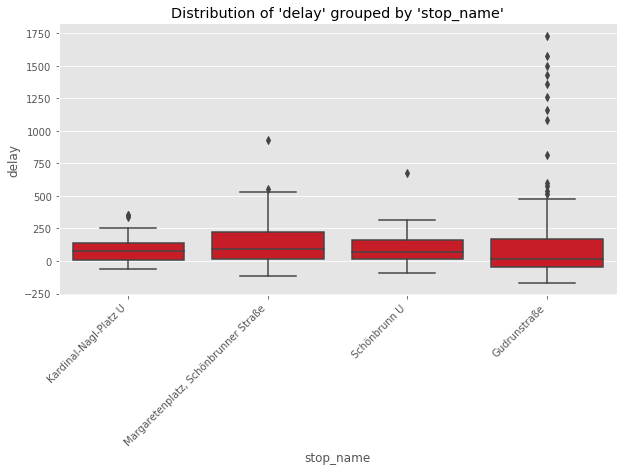

In [27]:
# get statistics of delays per stop_name
plot_boxplot(df_red, 'stop_name', 'delay')
df_red.groupby('stop_name')['delay'].describe()

Here it can be seen that the delays at the respective stops do differ somewhat. In the median, the stop 'Gudrunstraße' has the smallest deviation from the planned time with 18 seconds. This is even with a relatively large gap to the next best station. This is the one at 'Schönbrunn U' with 67.5 seconds. This is followed by 'Kardinal-Nagl-Platz U' with 77 seconds and bringing up the rear is the station at 'Margaretenplatz, Schönbrunner Straße' with 94 seconds. <br>
However, it can also be seen that 'Gudrunstraße' has an enormous variance. This means for reality that although there is a very small deviation in the median, this is a gamble. It can also be seen that a large proportion arrive at the stop too early. <br>

### How many Vehicle came too early?
Why is a delayed arrival of a vehicle a problem in reality? Normally, I personally always go to a station and wait until the next vehicle arrives. If I don't have an important appointment, this is not a problem. However, if I have an appointment at a certain time at a certain place, I check in advance when exactly a journey is planned. As this can be essential to arrive on time, it is very annoying if you go to the bus stop at a certain time and the planned vehicle has already left. In this case, one has to wait for the next vehicle and it is uncertain whether the appointment can be made. It is therefore interesting to see which stations are prone to early arrivals.

In [28]:
# Encode type of delay
# -1...Vehicle came early
# 0...Vehicle was exactly on time
# 1...Vehicle came late
df_red.loc[df_red['delay'] < 0, 'delay_type'] = -1
df_red.loc[df_red['delay'] > 0, 'delay_type'] = 1
df_red.loc[df_red['delay'] == 0, 'delay_type'] = 0

C:\Users\sschw\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\sschw\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


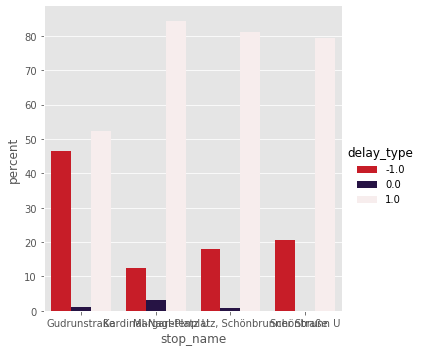

In [29]:
x,y = 'stop_name', 'delay_type'

_=(df_red
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar', palette = wl_palette))

It can be seen here that especially on Gudrunstrasse the ratio of early arrivals almost equals the proportion of late arrivals. Here it is about 46 to 51 percent. At the other stations this is much more unbalanced. The proportion of early arrivals ranges from 10 to just over 20 per cent. The proportion of vehicles arriving late here is between 78-85%.  <br>
Since several lines stop at Gudrunstrasse ('O', as well as '14A'), we will now investigate which of these two lines is responsible for several early arrivals.

TO BE CONTINUED!